# Tracing your Agent

In this lab, you will collect traces from your agent code:
- for OpenAI LLM calls, you will use OpenAIInstrumentor which automatically collects spans of type LLM containing the input and output of an LLM call;
- for any other steps of your agent you want to track, you will manually instrument them by creating corresponding spans.

When creating spans, you need to choose the [span kind](https://docs.arize.com/arize/llm-tracing/tracing/what-are-traces#span-kind). For this agent, you will create spans of types:
- chain: to represent the starting point of a chain of steps or a link between different steps;
- tool: to represent the call to an external tool;
- agent: to represent the main span that encompasses calls to LLMs and Tools.

Here's an example of how the spans might look like when you run the agent to respond to a user's query.
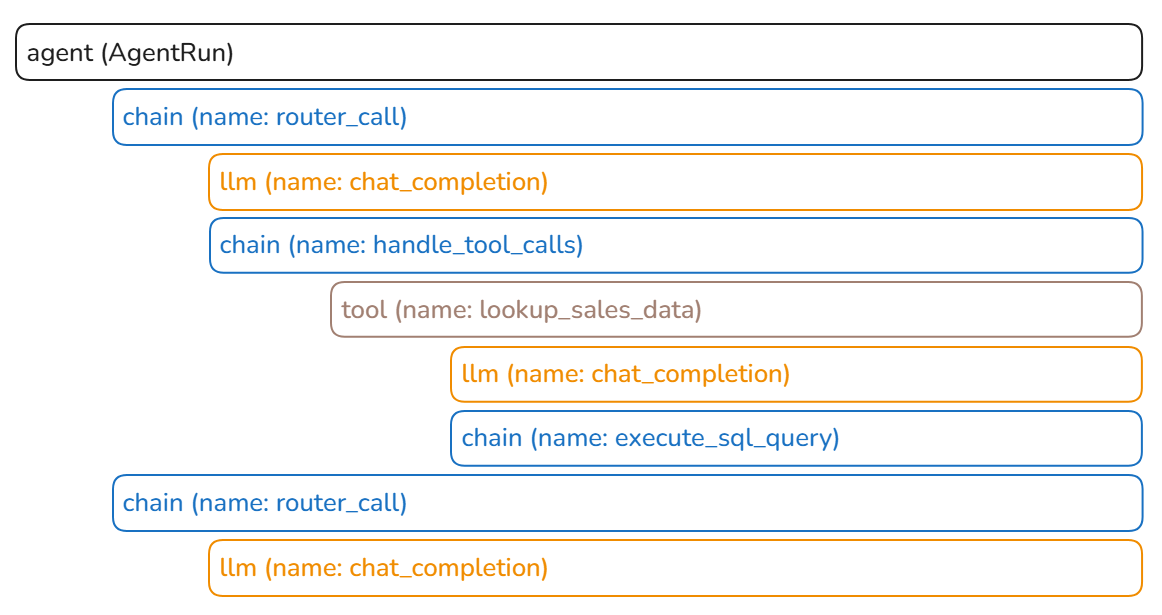

You will create a span of type `agent` to represent the main span (response of an agent to a user's query). Within this span, you will create a span of a type `chain` to represent a single router call, and to indicate that there will be a series of steps taken under this router call. This includes the main llm call made by the router which will be automatically collected, and a span to of type `chain` to represent how the tools were handled. Under this chain, you wil create a span of type `tool` for each tool executed and under each tool, there might an llm call and maybe another chain of steps.

This notebook contains the same code of the previous lab but with additional code that allows collecting traces from your code. Try to watch first the video to understand how the code is instrumented and then run all cells and at the end (**last code cell**), check out the **link to Phoenix UI** to examine the spans collected.

## Importing necessary libraries

In [ ]:
from openai import OpenAI
import pandas as pd
import json
import duckdb
from pydantic import BaseModel, Field
from IPython.display import Markdown

from helper import get_openai_api_key, get_phoenix_endpoint

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import phoenix as px
import os
from phoenix.otel import register
from openinference.instrumentation.openai import OpenAIInstrumentor
from openinference.semconv.trace import SpanAttributes
from opentelemetry.trace import Status, StatusCode
from openinference.instrumentation import TracerProvider

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their dynamic, probabilistic nature. Your results might differ from those shown in the video.</p>

## Initializing the OpenAI client

In [ ]:
# initialize the OpenAI client
openai_api_key = get_openai_api_key()
client = OpenAI(api_key=openai_api_key)

MODEL = "gpt-4o-mini"

# Phoenix

Phoenix is an AI observability platform that you can use to visualize the traces collected from your code. The Phoenix server is already launched for you, and you are provided with its endpoint (address) so you can configure a TracerProvider to send traces to Phoenix.

**Note**: You can launch a local version of Phoenix in your own local notebook environment using `session = px.launch_app()` (as shown [here](https://docs.arize.com/phoenix/deployment/environments#notebooks)). In this notebook, you don't need to launch the Phoenix server, it's already configured for you.

In [ ]:
PROJECT_NAME = "tracing-agent"

In [ ]:
tracer_provider = register(
    project_name=PROJECT_NAME,
    endpoint= get_phoenix_endpoint() + "v1/traces"
)

🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: tracing-agent
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: https://s172-29-66-17p6006.lab-aws-production.deeplearning.ai/v1/traces
|  Transport: HTTP + protobuf
|  Transport Headers: {}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



**Note**: To check Phoenix UI, you can open the link provided in the last code cell. The link shown in the output of the previous cell includes this additional string "v1/traces" and represents where the traces will be collected not the UI.

Setup the OpenAIInsrumentor to automatically collect OpenAI LLM calls from your code.

In [ ]:
OpenAIInstrumentor().instrument(tracer_provider = tracer_provider)

Get the tracer (object that creates spans) from the tracer provider (object that provides/sends the collected traces to Phoenix). You will use the tracer object to create the chain, tool and agent spans.

In [ ]:
tracer = tracer_provider.get_tracer(__name__)

## Defining the tools

### Tool 1: Database Lookup

In [ ]:
# define the path to the transactional data
TRANSACTION_DATA_FILE_PATH = 'data/Store_Sales_Price_Elasticity_Promotions_Data.parquet'

In [ ]:
# prompt template for step 2 of tool 1
SQL_GENERATION_PROMPT = """
Generate an SQL query based on a prompt. Do not reply with anything besides the SQL query.
The prompt is: {prompt}

The available columns are: {columns}
The table name is: {table_name}
"""

In [ ]:
# code for step 2 of tool 1
def generate_sql_query(prompt: str, columns: list, table_name: str) -> str:
    """Generate an SQL query based on a prompt"""
    formatted_prompt = SQL_GENERATION_PROMPT.format(prompt=prompt,
                                                    columns=columns,
                                                    table_name=table_name)

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
    )

    return response.choices[0].message.content

In [ ]:
# code for tool 1
@tracer.tool()
def lookup_sales_data(prompt: str) -> str:
    """Implementation of sales data lookup from parquet file using SQL"""
    try:

        # define the table name
        table_name = "sales"

        # step 1: read the parquet file into a DuckDB table
        df = pd.read_parquet(TRANSACTION_DATA_FILE_PATH)
        duckdb.sql(f"CREATE TABLE IF NOT EXISTS {table_name} AS SELECT * FROM df")

        # step 2: generate the SQL code
        sql_query = generate_sql_query(prompt, df.columns, table_name)
        # clean the response to make sure it only includes the SQL code
        sql_query = sql_query.strip()
        sql_query = sql_query.replace("```sql", "").replace("```", "")

        with tracer.start_as_current_span(
            "execute_sql_query",
            openinference_span_kind="chain"
        ) as span:
            span.set_input(sql_query)
            # step 3: execute the SQL query
            result = duckdb.sql(sql_query).df()
            span.set_output(value=str(result))
            span.set_status(StatusCode.OK)

        return result.to_string()
    except Exception as e:
        return f"Error accessing data: {str(e)}"

### Tool 2: Data Analysis

In [ ]:
# Construct prompt based on analysis type and data subset
DATA_ANALYSIS_PROMPT = """
Analyze the following data: {data}
Your job is to answer the following question: {prompt}
"""

In [ ]:
# code for tool 2
@tracer.tool()
def analyze_sales_data(prompt: str, data: str) -> str:
    """Implementation of AI-powered sales data analysis"""
    formatted_prompt = DATA_ANALYSIS_PROMPT.format(data=data, prompt=prompt)

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
    )

    analysis = response.choices[0].message.content
    return analysis if analysis else "No analysis could be generated"

### Tool 3: Data Visualization

In [ ]:
# prompt template for step 1 of tool 3
CHART_CONFIGURATION_PROMPT = """
Generate a chart configuration based on this data: {data}
The goal is to show: {visualization_goal}
"""

In [ ]:
# class defining the response format of step 1 of tool 3
class VisualizationConfig(BaseModel):
    chart_type: str = Field(..., description="Type of chart to generate")
    x_axis: str = Field(..., description="Name of the x-axis column")
    y_axis: str = Field(..., description="Name of the y-axis column")
    title: str = Field(..., description="Title of the chart")

In [ ]:
# code for step 1 of tool 3
@tracer.chain()
def extract_chart_config(data: str, visualization_goal: str) -> dict:
    """Generate chart visualization configuration

    Args:
        data: String containing the data to visualize
        visualization_goal: Description of what the visualization should show

    Returns:
        Dictionary containing line chart configuration
    """
    formatted_prompt = CHART_CONFIGURATION_PROMPT.format(data=data,
                                                         visualization_goal=visualization_goal)

    response = client.beta.chat.completions.parse(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
        response_format=VisualizationConfig,
    )

    try:
        # Extract axis and title info from response
        content = response.choices[0].message.content

        # Return structured chart config
        return {
            "chart_type": content.chart_type,
            "x_axis": content.x_axis,
            "y_axis": content.y_axis,
            "title": content.title,
            "data": data
        }
    except Exception:
        return {
            "chart_type": "line",
            "x_axis": "date",
            "y_axis": "value",
            "title": visualization_goal,
            "data": data
        }

In [ ]:
CREATE_CHART_PROMPT = """
Write python code to create a chart based on the following configuration.
Only return the code, no other text.
config: {config}
"""

In [ ]:
# code for step 2 of tool 3
@tracer.chain()
def create_chart(config: dict) -> str:
    """Create a chart based on the configuration"""
    formatted_prompt = CREATE_CHART_PROMPT.format(config=config)

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
    )

    code = response.choices[0].message.content
    code = code.replace("```python", "").replace("```", "")
    code = code.strip()

    return code

In [ ]:
# code for tool 3
@tracer.tool()
def generate_visualization(data: str, visualization_goal: str) -> str:
    """Generate a visualization based on the data and goal"""
    config = extract_chart_config(data, visualization_goal)
    code = create_chart(config)
    return code

## Tool Schema

In [ ]:
# Define tools/functions that can be called by the model
tools = [
    {
        "type": "function",
        "function": {
            "name": "lookup_sales_data",
            "description": "Look up data from Store Sales Price Elasticity Promotions dataset",
            "parameters": {
                "type": "object",
                "properties": {
                    "prompt": {"type": "string", "description": "The unchanged prompt that the user provided."}
                },
                "required": ["prompt"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "analyze_sales_data",
            "description": "Analyze sales data to extract insights",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                    "prompt": {"type": "string", "description": "The unchanged prompt that the user provided."}
                },
                "required": ["data", "prompt"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "generate_visualization",
            "description": "Generate Python code to create data visualizations",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                    "visualization_goal": {"type": "string", "description": "The goal of the visualization."}
                },
                "required": ["data", "visualization_goal"]
            }
        }
    }
]

# Dictionary mapping function names to their implementations
tool_implementations = {
    "lookup_sales_data": lookup_sales_data,
    "analyze_sales_data": analyze_sales_data,
    "generate_visualization": generate_visualization
}

## Router Logic

In [ ]:
# code for executing the tools returned in the model's response
@tracer.chain()
def handle_tool_calls(tool_calls, messages):

    for tool_call in tool_calls:
        function = tool_implementations[tool_call.function.name]
        function_args = json.loads(tool_call.function.arguments)
        result = function(**function_args)
        messages.append({"role": "tool",
                         "content": result,
                         "tool_call_id": tool_call.id})

    return messages

In [ ]:
SYSTEM_PROMPT = """
You are a helpful assistant that can answer questions about the Store Sales Price Elasticity Promotions dataset.
"""

In [ ]:
def run_agent(messages):
    print("Running agent with messages:", messages)
    if isinstance(messages, str):
        messages = [{"role": "user", "content": messages}]
    if not any(
            isinstance(message, dict) and message.get("role") == "system" for message in messages
        ):
            system_prompt = {"role": "system", "content": SYSTEM_PROMPT}
            messages.append(system_prompt)

    while True:
        # Router Span
        print("Starting router call span")
        with tracer.start_as_current_span(
            "router_call", openinference_span_kind="chain",
        ) as span:
            span.set_input(value=messages)

            response = client.chat.completions.create(
                model=MODEL,
                messages=messages,
                tools=tools,
            )
            messages.append(response.choices[0].message.model_dump())
            tool_calls = response.choices[0].message.tool_calls
            print("Received response with tool calls:", bool(tool_calls))
            span.set_status(StatusCode.OK)

            if tool_calls:
                print("Starting tool calls span")
                messages = handle_tool_calls(tool_calls, messages)
                span.set_output(value=tool_calls)
            else:
                print("No tool calls, returning final response")
                span.set_output(value=response.choices[0].message.content)
                return response.choices[0].message.content

In [ ]:
def start_main_span(messages):
    print("Starting main span with messages:", messages)

    with tracer.start_as_current_span(
        "AgentRun", openinference_span_kind="agent"
    ) as span:
        span.set_input(value=messages)
        ret = run_agent(messages)
        print("Main span completed with return value:", ret)
        span.set_output(value=ret)
        span.set_status(StatusCode.OK)
        return ret

In [ ]:
result = start_main_span([{"role": "user",
                           "content": "Which stores did the best in 2021?"}])

Starting main span with messages: [{'role': 'user', 'content': 'Which stores did the best in 2021?'}]
Running agent with messages: [{'role': 'user', 'content': 'Which stores did the best in 2021?'}]
Starting router call span
Received response with tool calls: True
Starting tool calls span
Starting router call span
Received response with tool calls: True
Starting tool calls span
Starting router call span
Received response with tool calls: False
No tool calls, returning final response
Main span completed with return value: The best performing stores in 2021 based on Total Quantity Sold and Total Sales Value are:

1. **Store 2970**
   - Total Quantity Sold: 5867 units
   - Total Sales Value: $84,454.33

2. **Store 3300**
   - Total Quantity Sold: 5124 units
   - Total Sales Value: $63,205.33

3. **Store 1650**
   - Total Quantity Sold: 4673 units
   - Total Sales Value: $62,152.43

These stores excelled in both quantity sold and sales revenue, indicating strong overall sales performance d

## Link to Phoenix UI

After you run all code cells, you can open this link to check out the Phoenix UI and observe the collected spans.

**Note**:  Make sure that the notebook's kernel is running when checking the Phoenix UI. If the link does not open, it might be because the notebook has been open or inactive for a long time. In that case, make sure to refresh the browser, run all cells and then check this link. The link provided in this notebook is different from the one shown in the video.

In [ ]:
print(get_phoenix_endpoint())

https://s172-29-66-17p6006.lab-aws-production.deeplearning.ai/
